In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 
import seaborn as sns

## 1. Base model

In [2]:
# parameters of MM (market maker)
gamma = 0.1  # risk-aversion of MM

# parameters of market simulation
L = 210  # market orders per T (Poisson lambda)
alpha = 1.5  # power law distribution of market order volumes
k = 1.5  # coefficient k for lambda(delta) = A * exp(-k*delta), k = alpha*K => K = 1
A = L / alpha  # A = L / A = 140 => L=210

# Time parameters
T = 1  # time horizon
dt = 0.005  # time quant

# Brownian motion parameters
mu = 0.0
sigma = 2  # brownian motion

In [3]:
A * dt

0.7000000000000001

In [4]:
# lambda estimation
A * dt * np.exp(-k * 0.0001 * 100)

0.6895783577221439

In [5]:
# Now it doesn't in use 
def brownian_motion(mu=0., sigma=1., dt=1., steps=1, s=0.0):
    '''
    Function returns Brownian motion price 
    dS = mu * dt + sigma * sqrt(dt) * E, E - std normal
    Parameters
    s - start price
    dt - time quant
    mu, sigma - normal distribution parameters
    '''
    return s + np.cumsum(np.ones(steps)*mu*dt + np.random.randn(steps)*sigma*dt**0.5) 


def market_order_touch_limit(A, k, delta, dt):
    '''
    A = L/alpha and k = alpha*K - market parameters
    delta - distance from mid
    dt - time quant
    Returns True if market order happens and touch limit
    '''
    
    prob = A * np.exp(-k * delta) * dt
    return (np.random.uniform() < prob/2)  # div 2 because use twice for buy and sell 

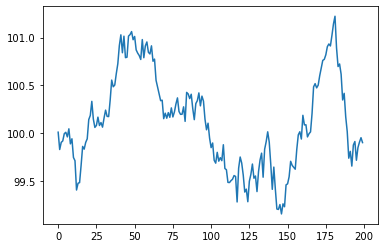

In [6]:
# trajectory example
plt.plot(brownian_motion(mu=0, sigma=2, dt=0.005, steps=200, s=100))

In [7]:
def mm_limit_order(s, t, q, sigma, gamma, k, T):
    '''
    s - current price
    t - current time
    q - current inventory

    sigma -  standart deviation of mid price brownian motion parameters
    k - market parameter
    T - time horizon
    gamma - risk aversion
    '''

    theta_1 = s
    theta_2 = - sigma**2 * gamma * (T-t)
    
    resrv_price = theta_1 + theta_2*q    
    spread = -theta_2 + 2/gamma * np.log(1+gamma/k)
    
    return resrv_price, spread

In [8]:
start_price = 100

In [9]:
def simulation_run(start_price, gamma, A, k, T, dt, mu, sigma):
    '''
    Run one simulation
    Return dataframe with deals
    '''
    
    t = 0  # start time
    mid = start_price  # start price

    data = {'Time': [t],
            'Wealth': [0],
            'Inventory': [0],
            'Deal side': ['-'],
            'Mid': [mid],
            'Bid': [mid],
            'Ask': [mid],
            'R-price': [mid],
            'Spread': [0],
            'PnL': [0]}
    df_deals = pd.DataFrame.from_dict(data)

    W = 0  # initial wealth (t=0)
    Q = 0  # initial stock inventory
    PnL = 0  # PnL

    for t in np.arange(dt, T+dt, dt):
        mid += mu * dt + np.random.randn() * sigma * dt**0.5  # next mid price
        # limit order parameters
        r_price, spread = mm_limit_order(mid, t, Q, sigma, gamma, k, T)
        mm_bid, mm_ask = r_price-spread/2, r_price+spread/2
        delta_bid = mid - mm_bid
        delta_ask = mm_ask - mid

        side = ''
        if market_order_touch_limit(A, k, delta_bid, dt):
            # bid order execution
            Q += 1
            W -= mm_bid
            side += 'B'

        if market_order_touch_limit(A, k, delta_ask, dt):
            # ask order execution
            Q -= 1
            W += mm_ask
            side += 'S'

        PnL =  Q * mid + W  # PnL uses mid for inventory valuation

        # update dataframe
        data = {'Time': t,
                'Wealth': W,
                'Inventory': Q,
                'Deal side': side,
                'Mid': mid,
                'Bid': mm_bid,
                'Ask': mm_ask,
                'R-price': r_price,
                'Spread': spread,
                'PnL': PnL}
        df_deals = df_deals.append(data, ignore_index=True)
        
    return df_deals

In [10]:
def simulation_symm_run(start_price, spread_start, spread_end, T, dt, mu, sigma):
    '''
    Run simulation with simple strategy
    Spread around the mid price
    Spread is a linear function of time, in the most simple case constant 
    '''
    
    t = 0  # start time
    mid = start_price  # start price

    data = {'Time': [t],
            'Wealth': [0],
            'Inventory': [0],
            'Deal side': ['-'],
            'Mid': [mid],
            'Bid': [mid],
            'Ask': [mid],
            'R-price': [mid],
            'Spread': [0],
            'PnL': [0]}
    df_deals = pd.DataFrame.from_dict(data)

    W = 0  # initial wealth (t=0)
    Q = 0  # initial stock inventory
    PnL = 0  # PnL
    
    for spread in np.linspace(spread_start, spread_end, int(T/dt)):
        mid += mu * dt + np.random.randn() * sigma * dt**0.5  # next mid price
        # limit order parameters
        
        mm_bid, mm_ask = mid-spread/2, mid+spread/2

        side = ''
        if market_order_touch_limit(A, k, spread/2, dt):
            # bid order execution
            Q += 1
            W -= mm_bid
            side += 'B'

        if market_order_touch_limit(A, k, spread/2, dt):
            # ask order execution
            Q -= 1
            W += mm_ask
            side += 'S'

        PnL =  Q * mid + W  # PnL uses mid for inventory

        # update dataframe
        data = {'Time': t,
                'Wealth': W,
                'Inventory': Q,
                'Deal side': side,
                'Mid': mid,
                'Bid': mm_bid,
                'Ask': mm_ask,
                'R-price': mid,
                'Spread': spread,
                'PnL': PnL}
        df_deals = df_deals.append(data, ignore_index=True)
        
    return df_deals  

In [11]:
# Example run
df_deals = simulation_run(start_price, gamma, A, k, T, dt, mu, sigma)
df_deals = df_deals[1:]

In [12]:
df_deals[:5]

,Time,Wealth,Inventory,Deal side,Mid,Bid,Ask,R-price,Spread,PnL
1,0.005,101.219514,-1,S,100.375129,99.530744,101.219514,100.375129,1.68877,0.844385
2,0.010,101.219514,-1,,100.226429,99.779044,101.465814,100.622429,1.68677,0.993086
3,0.015,101.219514,-1,,100.007319,99.558934,101.243704,100.401319,1.68477,1.212195
4,0.020,101.219514,-1,,100.070658,99.621273,101.304044,100.462658,1.68277,1.148856
5,0.025,101.219514,-1,,100.196252,99.745867,101.426637,100.586252,1.68077,1.023263


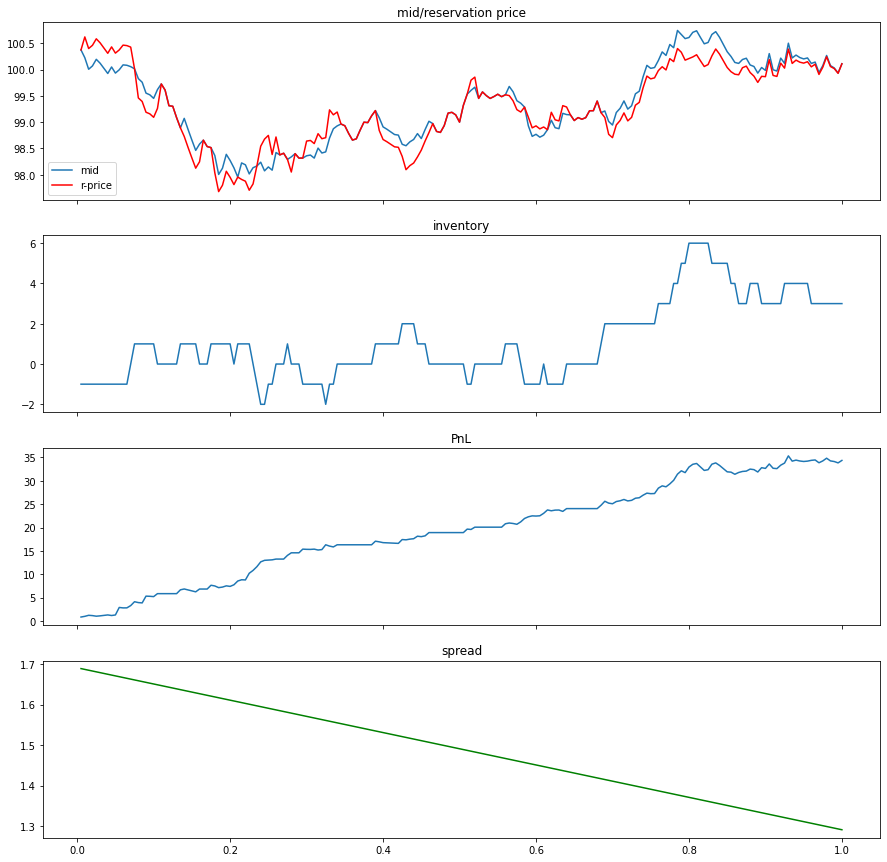

In [13]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(15, 15))

axes[0].plot(df_deals['Time'], df_deals['Mid'], label='mid')
axes[0].plot(df_deals['Time'], df_deals['R-price'], 'r', label='r-price')
axes[0].title.set_text('mid/reservation price')
axes[0].legend()

axes[1].plot(df_deals['Time'], df_deals['Inventory'], label='inventory')
axes[1].title.set_text('inventory')

axes[2].plot(df_deals['Time'], df_deals['PnL'], label='PnL')
axes[2].title.set_text('PnL')

axes[3].plot(df_deals['Time'], df_deals['Spread'], 'g', label='spread')
axes[3].title.set_text('spread')

In [ ]:
gamme = 0.1

In [14]:
columns = ['PnL inv', 'Final Q inv', 'PnL symm', 'Final Q symm', 'PnL const', 'Final Q const']

df_simres = pd.DataFrame(columns=columns)

for _ in tqdm.tqdm_notebook(range(1000)):
    # base model
    df_deals = simulation_run(start_price, 
                              gamma, A, k, 
                              T, dt, mu, sigma)
    # same spread as in base model, but around mid
    df_deals_symm = simulation_symm_run(start_price, 
                                           df_deals['Spread'].iloc[1], df_deals['Spread'].iloc[-1],
                                           T, dt, mu, sigma)
    # simple symmetric constant spread
    avg_spread = df_deals['Spread'].mean()
    df_deals_symm_const = simulation_symm_run(start_price,
                                                 avg_spread, avg_spread,
                                                 T, dt, mu, sigma)
    
    data = {
        'PnL inv': df_deals['PnL'].iloc[-1],
        'Final Q inv': df_deals['Inventory'].iloc[-1],
        'PnL symm': df_deals_symm['PnL'].iloc[-1],
        'Final Q symm': df_deals_symm['Inventory'].iloc[-1],        
        'PnL const': df_deals_symm_const['PnL'].iloc[-1],
        'Final Q const': df_deals_symm_const['Inventory'].iloc[-1],
    }
    
    df_simres = df_simres.append(data, ignore_index=True)

/tmp/ipykernel_21805/2937659219.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm.tqdm_notebook(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
df_simres_01 = df_simres.copy()
df_simres_01[:5]

,PnL inv,Final Q inv,PnL symm,Final Q symm,PnL const,Final Q const
0,26.852655,-2.0,28.850289,-9.0,29.088071,6.0
1,29.927827,1.0,26.135377,-5.0,42.608289,-13.0
2,29.618707,-3.0,29.539837,13.0,26.441543,-7.0
3,32.612663,2.0,30.724584,8.0,23.788954,7.0
4,39.495079,0.0,70.462393,11.0,50.100271,9.0


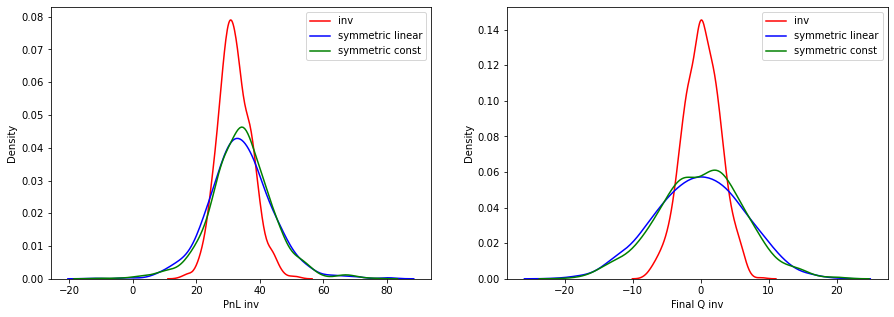

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(data=df_simres_01, x='PnL inv', color='r', ax=axes[0], label='inv')
sns.kdeplot(data=df_simres_01, x='PnL symm', color='b', ax=axes[0], label='symmetric linear')
sns.kdeplot(data=df_simres_01, x='PnL const', color='g', ax=axes[0], label='symmetric const')
axes[0].legend()

sns.kdeplot(data=df_simres_01, x='Final Q inv', color='r', ax=axes[1], label='inv')
sns.kdeplot(data=df_simres_01, x='Final Q symm', color='b', ax=axes[1], label='symmetric linear')
sns.kdeplot(data=df_simres_01, x='Final Q const', color='g', ax=axes[1], label='symmetric const')
axes[1].legend()


In [17]:
# Same simulation for gamma = 1
gamma = 1

In [18]:
columns = ['PnL inv', 'Final Q inv', 'PnL symm', 'Final Q symm', 'PnL const', 'Final Q const']

df_simres = pd.DataFrame(columns=columns)

for _ in tqdm.tqdm_notebook(range(1000)):
    # base model
    df_deals = simulation_run(start_price, 
                              gamma, A, k, 
                              T, dt, mu, sigma)
    # same spread as in base model, but around mid
    df_deals_symm = simulation_symm_run(start_price, 
                                           df_deals['Spread'].iloc[1], df_deals['Spread'].iloc[-1],
                                           T, dt, mu, sigma)
    # simple symmetric constant spread
    avg_spread = df_deals['Spread'].mean()
    df_deals_symm_const = simulation_symm_run(start_price,
                                                 avg_spread, avg_spread,
                                                 T, dt, mu, sigma)
    
    data = {
        'PnL inv': df_deals['PnL'].iloc[-1],
        'Final Q inv': df_deals['Inventory'].iloc[-1],
        'PnL symm': df_deals_symm['PnL'].iloc[-1],
        'Final Q symm': df_deals_symm['Inventory'].iloc[-1],        
        'PnL const': df_deals_symm_const['PnL'].iloc[-1],
        'Final Q const': df_deals_symm_const['Inventory'].iloc[-1],
    }
    
    df_simres = df_simres.append(data, ignore_index=True)

/tmp/ipykernel_21805/4026984097.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm.tqdm_notebook(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [34]:
df_simres_1 = df_simres.copy()
df_simres_1[:5]

,PnL inv,Final Q inv,PnL symm,Final Q symm,PnL const,Final Q const
0,14.476826,0.0,41.301947,5.0,15.912627,5.0
1,12.342639,1.0,16.921969,4.0,16.879110,-6.0
2,15.608663,0.0,13.171970,0.0,30.280461,6.0
3,15.913159,1.0,20.365907,11.0,16.304103,-2.0
4,20.564816,0.0,25.966018,2.0,13.629020,0.0


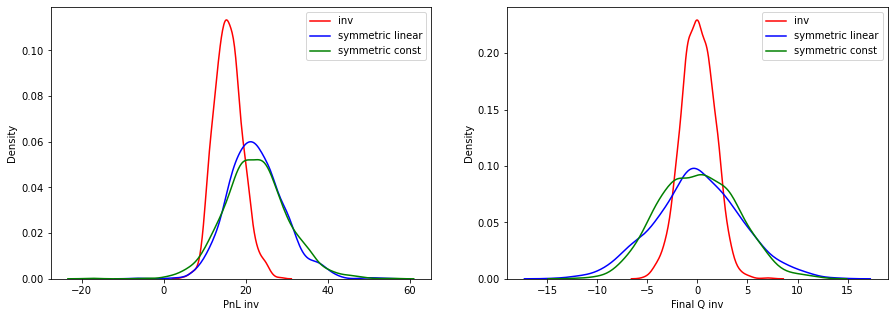

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(data=df_simres_1, x='PnL inv', color='r', ax=axes[0], label='inv')
sns.kdeplot(data=df_simres_1, x='PnL symm', color='b', ax=axes[0], label='symmetric linear')
sns.kdeplot(data=df_simres_1, x='PnL const', color='g', ax=axes[0], label='symmetric const')
axes[0].legend()

sns.kdeplot(data=df_simres_1, x='Final Q inv', color='r', ax=axes[1], label='inv', bw_adjust=1.3)
sns.kdeplot(data=df_simres_1, x='Final Q symm', color='b', ax=axes[1], label='symmetric linear')
sns.kdeplot(data=df_simres_1, x='Final Q const', color='g', ax=axes[1], label='symmetric const')
axes[1].legend()


## 2. Base model for USD/RUB

In [40]:
# parameters of MM (market maker)
gamma = 0.05  # risk-aversion of MM

# parameters of market simulation
L = 60*60 # number of market orders per T (Poisson lambda), I put it 1 a second ()
alpha = 1.5  # power law distribution of market order volumes
K = 30  # just manual selection for reasonable spread

# coefficient lambda(delta) = A * exp(-k*delta)
k = alpha * K 
A = L / alpha

# Time parameters
T = 1 / 8 # time horizon 1 hour
dt = 1 / 60 / 60  # time quant (1 sec)

# Brownian motion parameters (rough estimation)
mu = -0.05  # add little down drift 
sigma = 0.7  # brownian motion, daily historical std dev of USD/RUB

In [41]:
A * dt  # frequency of large market orders per dt

0.6666666666666666

In [42]:
# spread estimation
gamma * sigma**2 * 1 + 2/gamma * np.log(1+gamma/k)

0.06891977136108461

In [43]:
# lambda estimation for 0.01% spread
A * dt * np.exp(-k * 0.0001 * 70)

0.4865259161793712

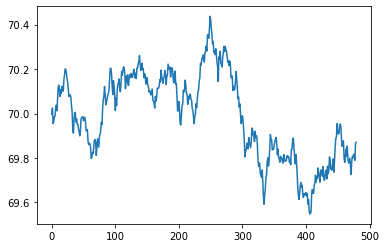

In [44]:
# trajectory example
plt.plot(brownian_motion(mu=mu, sigma=sigma, dt=1/8/60, steps=8*60, s=70))

In [45]:
start_price = 70

In [46]:
# Example run
df_deals = simulation_run(start_price, gamma, A, k, T, dt, mu, sigma)
df_deals = df_deals[1:]

In [47]:
i = 100
df_deals[i:i+10]

,Time,Wealth,Inventory,Deal side,Mid,Bid,Ask,R-price,Spread,PnL
101,0.028056,209.692419,-3,,69.844641,69.828369,69.875164,69.851766,0.046795,0.158497
102,0.028333,139.884457,-2,B,69.824251,69.807962,69.854750,69.831356,0.046788,0.235955
103,0.028611,139.884457,-2,,69.828922,69.810254,69.857035,69.833645,0.046781,0.226614
104,0.028889,139.884457,-2,,69.840450,69.821772,69.868547,69.845159,0.046774,0.203557
105,0.029167,70.048328,-1,B,69.854817,69.836129,69.882897,69.859513,0.046768,0.193511
106,0.029444,70.048328,-1,,69.847765,69.826725,69.873486,69.850106,0.046761,0.200563
107,0.029722,70.048328,-1,,69.835221,69.814178,69.860933,69.837556,0.046754,0.213107
108,0.030000,0.238354,0,B,69.831020,69.809974,69.856721,69.833348,0.046747,0.238354
109,0.030278,0.238354,0,,69.842008,69.818638,69.865378,69.842008,0.046740,0.238354
110,0.030556,-69.593317,1,B,69.855038,69.831671,69.878405,69.855038,0.046734,0.261721


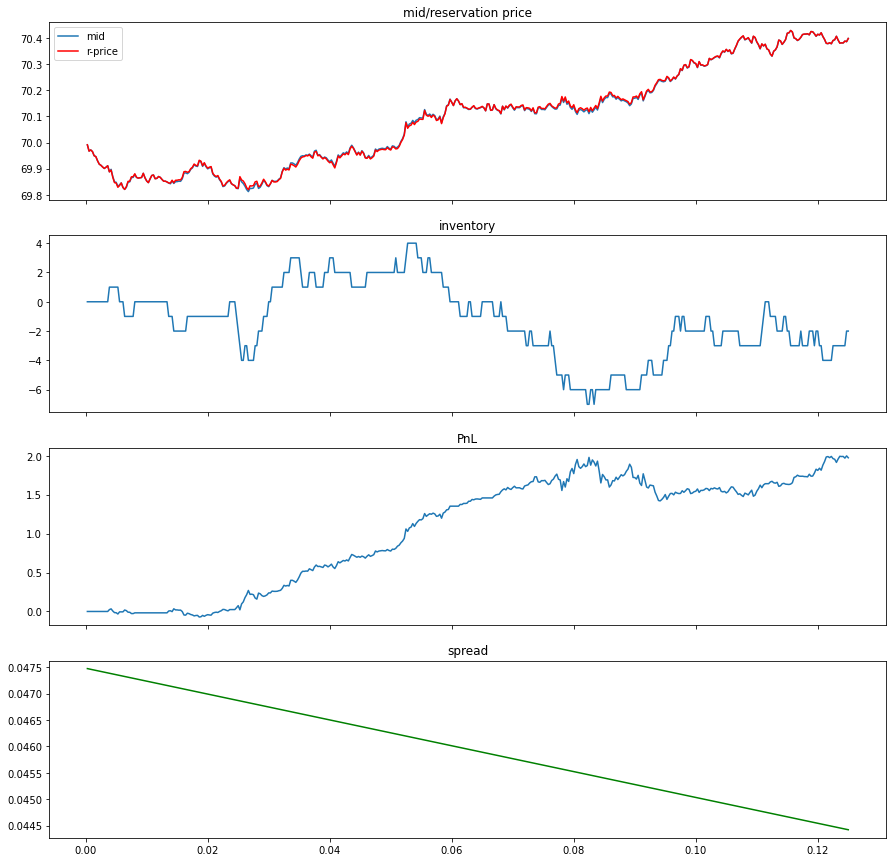

In [48]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(15, 15))

axes[0].plot(df_deals['Time'], df_deals['Mid'], label='mid')
axes[0].plot(df_deals['Time'], df_deals['R-price'], 'r', label='r-price')
axes[0].title.set_text('mid/reservation price')
axes[0].legend()

axes[1].plot(df_deals['Time'], df_deals['Inventory'], label='inventory')
axes[1].title.set_text('inventory')

axes[2].plot(df_deals['Time'], df_deals['PnL'], label='PnL')
axes[2].title.set_text('PnL')

axes[3].plot(df_deals['Time'], df_deals['Spread'], 'g', label='spread')
axes[3].title.set_text('spread')

In [49]:
columns = ['PnL inv', 'Final Q inv', 'PnL symm', 'Final Q symm', 'PnL const', 'Final Q const']

df_simres = pd.DataFrame(columns=columns)

for _ in tqdm.notebook.trange(300):
    # base model
    df_deals = simulation_run(start_price, 
                              gamma, A, k, 
                              T, dt, mu, sigma)
    # same spread as in base model, but around mid
    df_deals_symm = simulation_symm_run(start_price, 
                                           df_deals['Spread'].iloc[1], df_deals['Spread'].iloc[-1],
                                           T, dt, mu, sigma)
    # simple symmetric constant spread
    avg_spread = df_deals['Spread'].mean()
    df_deals_symm_const = simulation_symm_run(start_price,
                                                 avg_spread, avg_spread,
                                                 T, dt, mu, sigma)
    
    data = {
        'PnL inv': df_deals['PnL'].iloc[-1],
        'Final Q inv': df_deals['Inventory'].iloc[-1],
        'PnL symm': df_deals_symm['PnL'].iloc[-1],
        'Final Q symm': df_deals_symm['Inventory'].iloc[-1],        
        'PnL const': df_deals_symm_const['PnL'].iloc[-1],
        'Final Q const': df_deals_symm_const['Inventory'].iloc[-1],
    }
    
    df_simres = df_simres.append(data, ignore_index=True)

  0%|          | 0/300 [00:00<?, ?it/s]

In [50]:
df_simres[:5]

,PnL inv,Final Q inv,PnL symm,Final Q symm,PnL const,Final Q const
0,3.581866,-8.0,2.529023,-4.0,2.290280,-2.0
1,2.760961,-2.0,1.903514,6.0,3.129595,11.0
2,4.007726,-13.0,2.841846,0.0,4.271536,-5.0
3,2.269714,1.0,0.688224,5.0,4.565219,-14.0
4,2.889538,3.0,2.492918,2.0,2.745312,2.0


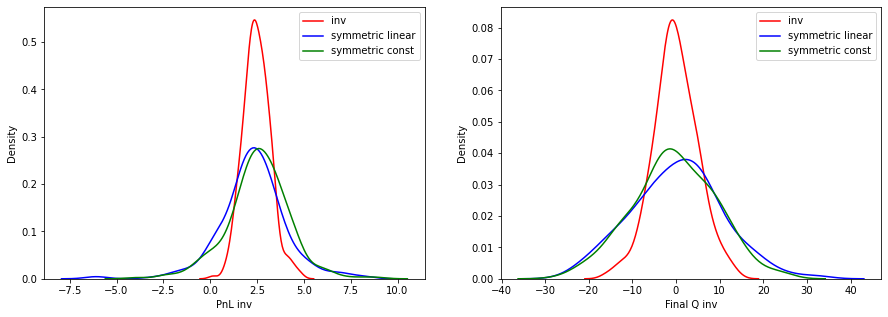

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(data=df_simres, x='PnL inv', color='r', ax=axes[0], label='inv')
sns.kdeplot(data=df_simres, x='PnL symm', color='b', ax=axes[0], label='symmetric linear')
sns.kdeplot(data=df_simres, x='PnL const', color='g', ax=axes[0], label='symmetric const')
axes[0].legend()

sns.kdeplot(data=df_simres, x='Final Q inv', color='r', ax=axes[1], label='inv')
sns.kdeplot(data=df_simres, x='Final Q symm', color='b', ax=axes[1], label='symmetric linear')
sns.kdeplot(data=df_simres, x='Final Q const', color='g', ax=axes[1], label='symmetric const')
axes[1].legend()
